In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
#Upload Data- Make sure data is loaded in your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Upload Data from Google Drive
file_path = '/content/drive/My Drive/Peer Review 1/clean_data.csv'

df = pd.read_csv(file_path)
df.head()



,voteintentionspain,edu3,dhincome_all,female,nativism,msexism,femdemonstrate
0,4,1,0.181818,1,0.45,0.203704,1
1,23,1,0.272727,1,0.65,0.555556,0
2,23,1,0.181818,1,0.75,0.388889,0
3,7,3,0.545455,0,0.35,0.203704,0
4,1,3,0.545455,1,0.65,0.407407,0


In [4]:
# STEP 2: Check column names and types
df.info()

# Clean column names if needed (remove whitespace, etc.)
df.columns = df.columns.str.strip()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3034 entries, 0 to 3033
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   voteintentionspain  3034 non-null   int64  
 1   edu3                3034 non-null   int64  
 2   dhincome_all        3034 non-null   float64
 3   female              3034 non-null   int64  
 4   nativism            3034 non-null   float64
 5   msexism             3034 non-null   float64
 6   femdemonstrate      3034 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 166.1 KB


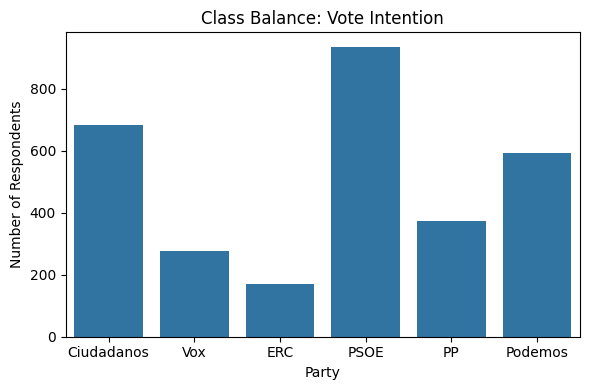

Class distribution (proportion of total):
party_label
PSOE          0.308
Ciudadanos    0.225
Podemos       0.196
PP            0.123
Vox           0.091
ERC           0.056
Name: proportion, dtype: float64


In [5]:
# STEP 3: Filter to 6 main Spanish political parties
target_parties = [1, 2, 3, 4, 7, 23]
df = df[df['voteintentionspain'].isin(target_parties)]

# Add readable party labels for plots (new)
party_map = {
    1: 'PSOE',
    2: 'PP',
    3: 'Podemos',
    4: 'Ciudadanos',
    7: 'ERC',
    23: 'Vox'
}
df['party_label'] = df['voteintentionspain'].map(party_map)

# STEP 4: Select predictors and target
features = ['nativism', 'msexism', 'femdemonstrate', 'female', 'dhincome_all']
target = 'voteintentionspain'
df = df[features + [target, 'party_label']].dropna()

# STEP 5: Clean categorical variables (make sure binary variables are integers)
df['female'] = df['female'].astype(int)
df['femdemonstrate'] = df['femdemonstrate'].astype(int)

# STEP 6: Scale continuous predictors (keep a scaled copy for modeling)
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['nativism', 'msexism', 'dhincome_all']] = scaler.fit_transform(
    df_scaled[['nativism', 'msexism', 'dhincome_all']]
)

# STEP 7: Check class balance using party labels
plt.figure(figsize=(6, 4))
sns.countplot(x='party_label', data=df)
plt.title('Class Balance: Vote Intention')
plt.xlabel('Party')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.show()

# Print normalized class frequencies
print("Class distribution (proportion of total):")
print(df['party_label'].value_counts(normalize=True).round(3))



2. Exploratory Data Analysis (EDA)

2.1 Histograms for ideology scores and income

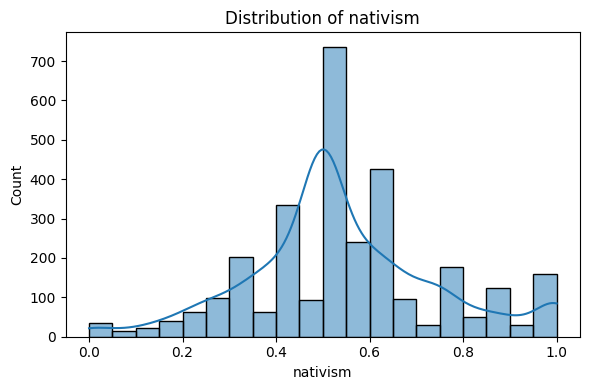

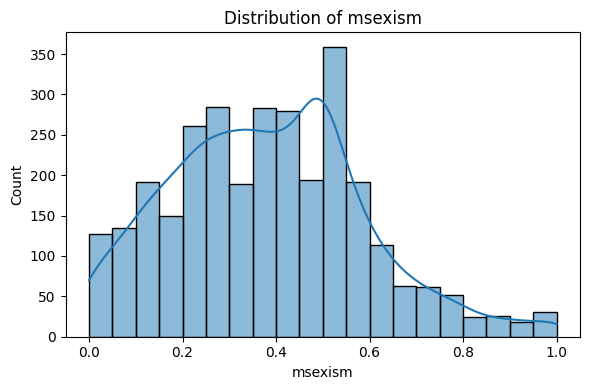

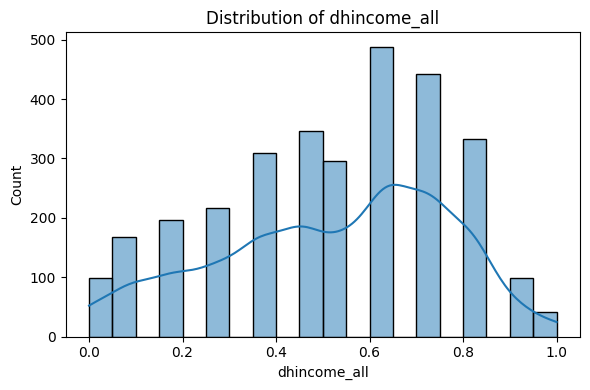

In [6]:
numeric_vars = ['nativism', 'msexism', 'dhincome_all']

for var in numeric_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[var], kde=True, bins=20)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


2.2 Bar plots for categorical variables

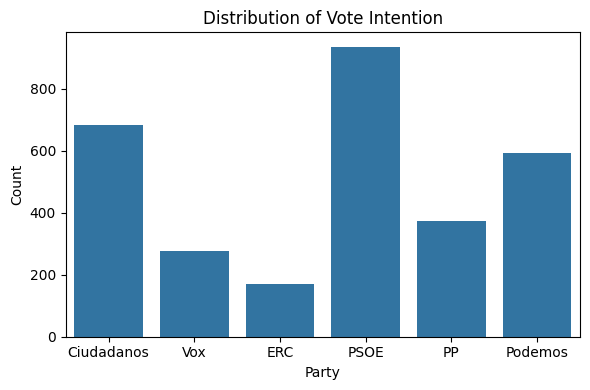

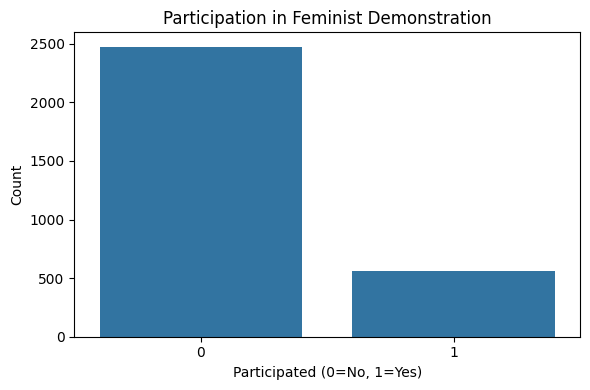

In [7]:
# Bar plot for vote intention
plt.figure(figsize=(6, 4))
sns.countplot(x='party_label', data=df)
plt.title('Distribution of Vote Intention')
plt.xlabel('Party')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Bar plot for feminist demonstration participation
plt.figure(figsize=(6, 4))
sns.countplot(x='femdemonstrate', data=df)
plt.title('Participation in Feminist Demonstration')
plt.xlabel('Participated (0=No, 1=Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


2.3 Boxplots of ideology scores by party

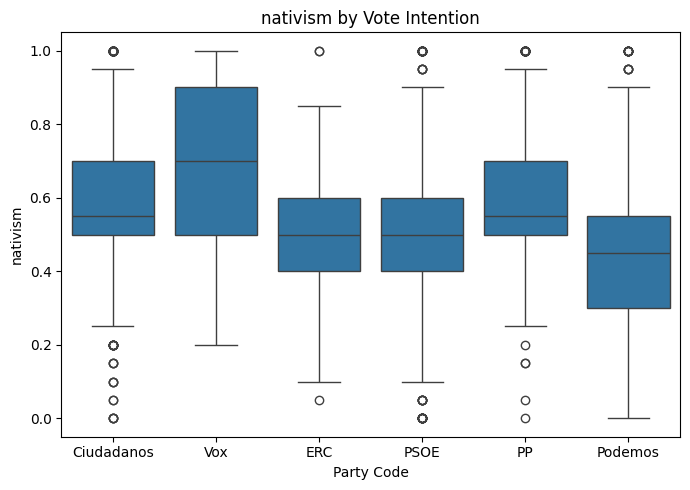

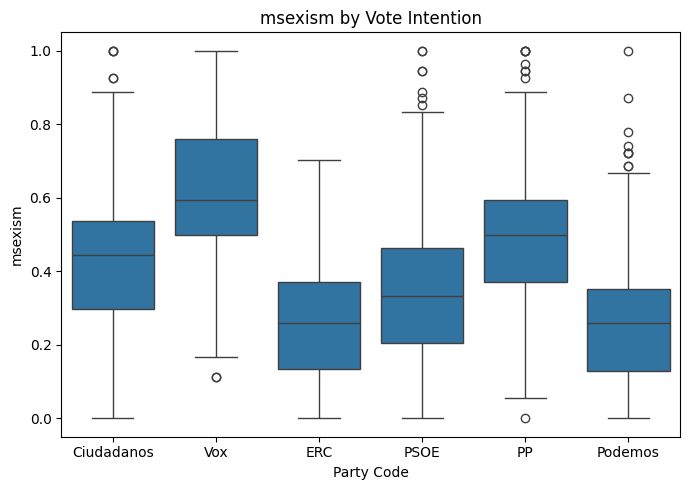

In [8]:
for var in ['nativism', 'msexism']:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x='party_label', y=var, data=df)
    plt.title(f'{var} by Vote Intention')
    plt.xlabel('Party Code')
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()

2.4 Correlation matrix of numeric predictors

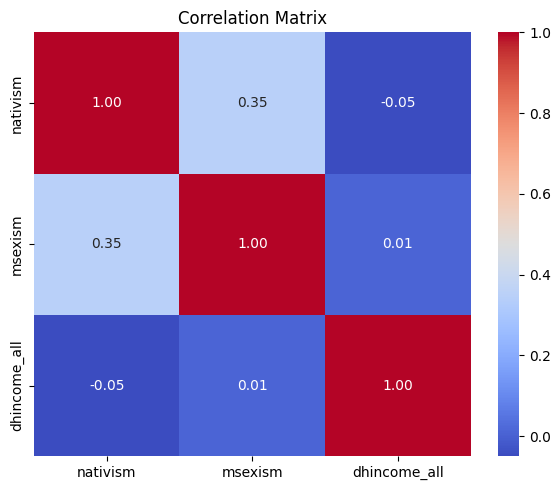

In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[['nativism', 'msexism', 'dhincome_all']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

2.5 Chi-square test for categorical associations

In [10]:
categorical_vars = ['femdemonstrate', 'female']

for var in categorical_vars:
    ct = pd.crosstab(df[var], df['party_label'])  # use readable labels
    chi2, p, dof, _ = chi2_contingency(ct)
    print(f"Chi-square Test: {var} vs party_label")
    print("Chi2:", round(chi2, 2), "| p-value:", round(p, 4), "| DoF:", dof)
    print("-" * 40)


Chi-square Test: femdemonstrate vs party_label
Chi2: 171.23 | p-value: 0.0 | DoF: 5
----------------------------------------
Chi-square Test: female vs party_label
Chi2: 40.34 | p-value: 0.0 | DoF: 5
----------------------------------------


3. Predictive Modeling

3.1 Random Forest Classifier

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'class_weight': 'balanced', 'bootstrap': False}
Classification Report:
              precision    recall  f1-score   support

        PSOE       0.43      0.16      0.23       187
          PP       0.23      0.36      0.28        75
     Podemos       0.43      0.34      0.38       119
  Ciudadanos       0.28      0.15      0.20       137
         ERC       0.11      0.53      0.18        34
         Vox       0.28      0.47      0.35        55

    accuracy                           0.27       607
   macro avg       0.30      0.34      0.27       607
weighted avg       0.34      0.27      0.27       607



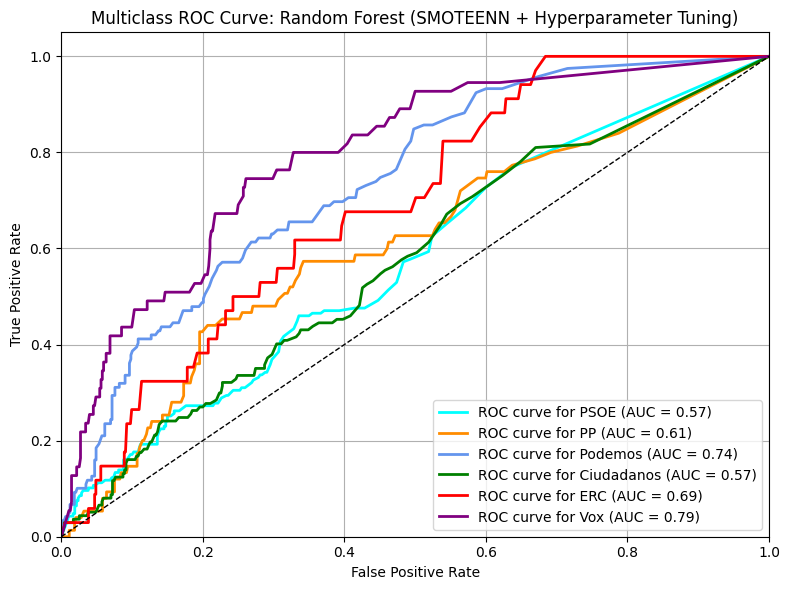


Mean Multiclass AUC: 0.663


In [11]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from sklearn.model_selection import train_test_split # Ensure train_test_split is imported

# Define X and y using the scaled DataFrame
# Include all features: scaled continuous and binary categorical
X = df_scaled[features]
y = df_scaled[target]


# Step 0: train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 1: Apply SMOTEENN on training set
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Step 2: Set up Random Forest and hyperparameter grid
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# Step 3: RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # number of parameter settings sampled
    scoring='f1_macro',  # macro F1 to handle imbalance
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled)

print(f"Best hyperparameters: {random_search.best_params_}")

# Step 4: Use best estimator to predict on test data
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# party_labels is already defined in a previous cell
party_labels = [party_map[c] for c in sorted(df_scaled[target].unique())]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=party_labels))

# Step 5: Compute ROC and AUC for each class
# Need to make sure the classes list is derived from the unique values in the target variable
# and that it matches the order of classes in the classifier's internal representation.
# Using best_rf.classes_ is the safest way.
y_test_bin = label_binarize(y_test, classes=best_rf.classes_)
y_score = best_rf.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'][:n_classes]) # Ensure enough colors
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
     # Use party_labels[i] for the label if the indices match best_rf.classes_ order
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {party_labels[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve: Random Forest (SMOTEENN + Hyperparameter Tuning)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

mean_auc = np.mean(list(roc_auc.values()))
print(f"\nMean Multiclass AUC: {mean_auc:.3f}")

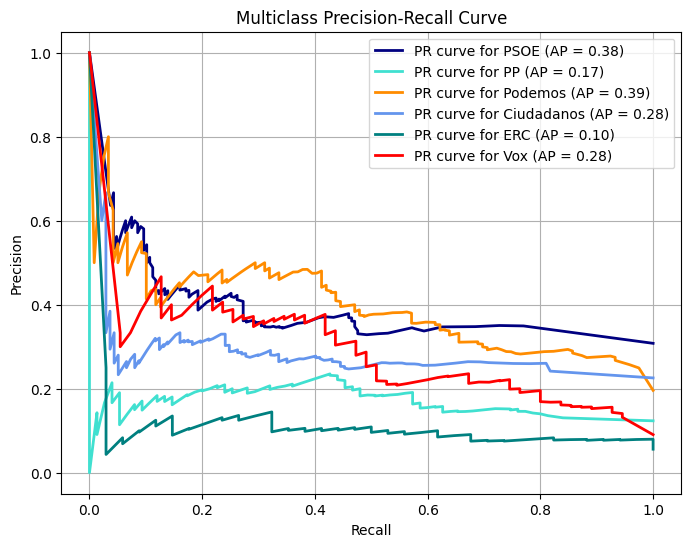

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Binarize test labels
y_test_bin = label_binarize(y_test, classes=best_rf.classes_)
y_score = best_rf.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(8, 6))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red'])

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PR curve for {party_labels[i]} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [13]:
from sklearn.metrics import f1_score

best_thresholds = dict()
optimal_f1_scores = dict()
y_pred_tuned = np.zeros_like(y_test_bin)

for i in range(n_classes):
    precisions, recalls, thresholds = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # avoid div by zero

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # thresholds is one less in length than precisions

    best_thresholds[i] = best_threshold
    optimal_f1_scores[i] = f1_scores[best_idx]

    # Apply threshold to get predicted labels for this class
    y_pred_tuned[:, i] = (y_score[:, i] >= best_threshold).astype(int)

print("Best thresholds per class:")
for i in range(n_classes):
    print(f"{party_labels[i]}: Threshold = {best_thresholds[i]:.3f}, Optimal F1 = {optimal_f1_scores[i]:.3f}")

# Convert multi-label predictions back to single-label by choosing class with highest probability
# among those above threshold, else default to class with highest probability
final_preds = []
for j in range(y_pred_tuned.shape[0]):
    positive_classes = np.where(y_pred_tuned[j] == 1)[0]
    if len(positive_classes) == 0:
        # No class passed threshold, pick max probability class
        pred = np.argmax(y_score[j])
    elif len(positive_classes) == 1:
        pred = positive_classes[0]
    else:
        # Multiple classes predicted, pick highest probability among them
        pred = positive_classes[np.argmax(y_score[j, positive_classes])]
    final_preds.append(best_rf.classes_[pred])

# Evaluate with tuned thresholds
from sklearn.metrics import classification_report

print("Classification Report with Tuned Thresholds:")
print(classification_report(y_test, final_preds, target_names=party_labels))


Best thresholds per class:
PSOE: Threshold = 0.003, Optimal F1 = 0.481
PP: Threshold = 0.303, Optimal F1 = 0.303
Podemos: Threshold = 0.193, Optimal F1 = 0.456
Ciudadanos: Threshold = 0.007, Optimal F1 = 0.394
ERC: Threshold = 0.683, Optimal F1 = 0.200
Vox: Threshold = 0.613, Optimal F1 = 0.397
Classification Report with Tuned Thresholds:
              precision    recall  f1-score   support

        PSOE       0.42      0.24      0.30       187
          PP       0.24      0.40      0.30        75
     Podemos       0.41      0.45      0.43       119
  Ciudadanos       0.28      0.22      0.25       137
         ERC       0.14      0.32      0.20        34
         Vox       0.38      0.42      0.40        55

    accuracy                           0.31       607
   macro avg       0.31      0.34      0.31       607
weighted avg       0.34      0.31      0.32       607



In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
import numpy as np

def threshold_tuning_cv(X, y, base_clf, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    classes = np.unique(y)
    n_classes = len(classes)

    thresholds_per_fold = []

    for train_idx, val_idx in skf.split(X, y):
        # Use iloc to select rows by integer position if X,y are DataFrames/Series
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        clf = base_clf.fit(X_train_cv, y_train_cv)

        y_val_bin = label_binarize(y_val_cv, classes=classes)
        y_score_val = clf.predict_proba(X_val_cv)

        fold_thresholds = []
        for i in range(n_classes):
            precisions, recalls, thr = precision_recall_curve(y_val_bin[:, i], y_score_val[:, i])
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
            best_idx = np.argmax(f1_scores)
            best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
            fold_thresholds.append(best_thr)
        thresholds_per_fold.append(fold_thresholds)

    avg_thresholds = np.mean(thresholds_per_fold, axis=0)
    return dict(zip(classes, avg_thresholds))


# Usage example:

base_rf = RandomForestClassifier(n_estimators=300, max_depth=40, class_weight='balanced',
                                 bootstrap=False, min_samples_leaf=1, min_samples_split=2, random_state=42)

# Run threshold tuning CV
tuned_thresholds = threshold_tuning_cv(X_train, y_train, base_rf, n_splits=5)

print("Tuned thresholds per class (from CV):")
for cls, thr in tuned_thresholds.items():
    print(f"{cls}: {thr:.3f}")


Tuned thresholds per class (from CV):
1: 0.116
2: 0.070
3: 0.180
4: 0.101
7: 0.176
23: 0.269


3.2 Multinomial Logistic Regression

              precision    recall  f1-score   support

        PSOE       0.35      0.16      0.22       187
          PP       0.20      0.32      0.24        75
     Podemos       0.40      0.36      0.38       119
  Ciudadanos       0.32      0.17      0.22       137
         ERC       0.14      0.56      0.23        34
         Vox       0.35      0.56      0.43        55

    accuracy                           0.28       607
   macro avg       0.29      0.35      0.29       607
weighted avg       0.32      0.28      0.27       607

Macro ROC AUC: 0.708

Odds Ratios:
            nativism  msexism  femdemonstrate  female  dhincome_all
PSOE            0.78     0.74            1.29    1.23          0.86
PP              1.19     1.93            0.60    1.36          1.02
Podemos         0.63     0.43            1.82    0.59          0.86
Ciudadanos      1.16     1.17            0.67    1.11          1.07
ERC             0.80     0.38            1.29    0.70          1.45
Vox           

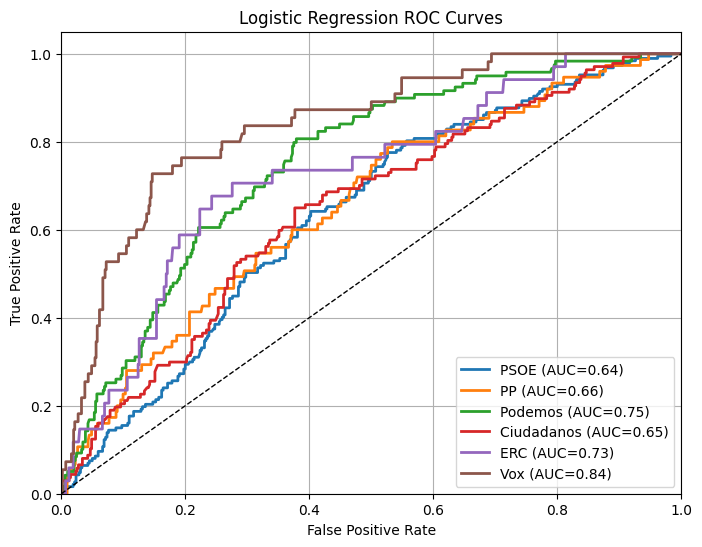

In [15]:


# 1. Train model
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
).fit(X_train, y_train)

# 2. Get predictions
y_pred = log_reg.predict(X_test)
y_probs = log_reg.predict_proba(X_test)

# 3. Print metrics
print(classification_report(y_test, y_pred, target_names=party_labels))
print(f"Macro ROC AUC: {roc_auc_score(label_binarize(y_test, classes=log_reg.classes_), y_probs, multi_class='ovr', average='macro'):.3f}")

# 4. Odds ratios
print("\nOdds Ratios:")
print(pd.DataFrame(np.exp(log_reg.coef_),
                  columns=features,
                  index=party_labels).round(2))

# 5. Combined ROC plot
plt.figure(figsize=(8,6))
for i, party in enumerate(log_reg.classes_):
    fpr, tpr, _ = roc_curve(y_test == party, y_probs[:, i])
    plt.plot(fpr, tpr, lw=2,
             label=f'{party_labels[i]} (AUC={auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

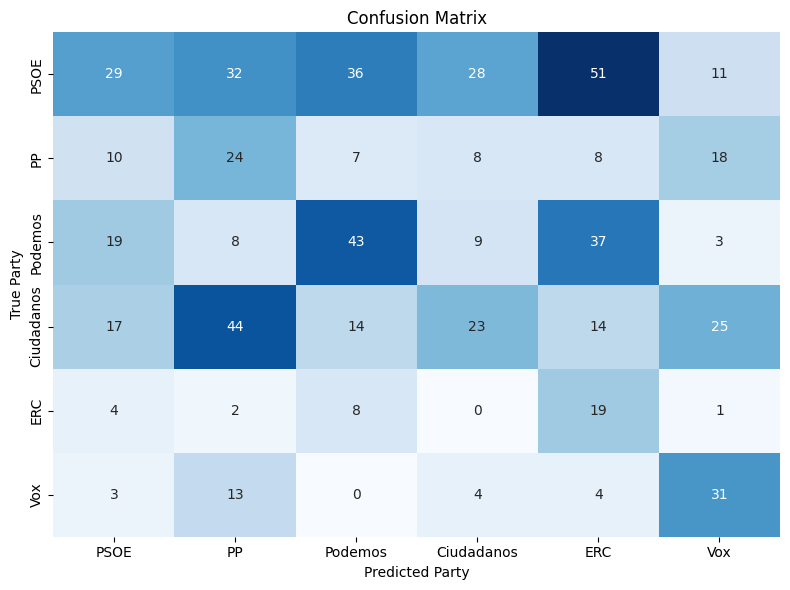

In [16]:
# Generate predictions (using existing model)
y_pred = log_reg.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=party_labels,
            yticklabels=party_labels,
            cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Party')
plt.ylabel('True Party')
plt.tight_layout()
plt.show()

3.3 K-Nearest Neighbors (KNN) with hyperparameter tuning---Ling

✅ Best K = 20, CV Accuracy = 0.388


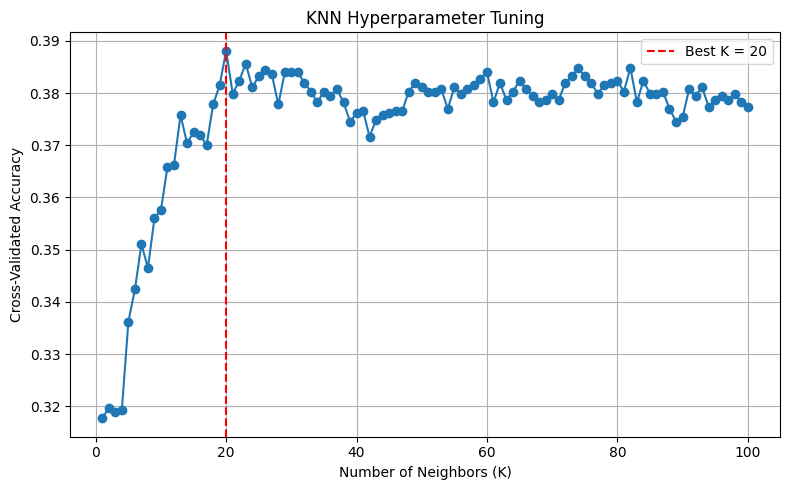

📋 Classification Report:
              precision    recall  f1-score   support

           1       0.37      0.64      0.46       187
           2       0.16      0.08      0.11        75
           3       0.40      0.27      0.32       119
           4       0.37      0.36      0.36       137
           7       0.00      0.00      0.00        34
          23       0.37      0.18      0.24        55

    accuracy                           0.36       607
   macro avg       0.28      0.25      0.25       607
weighted avg       0.33      0.36      0.32       607



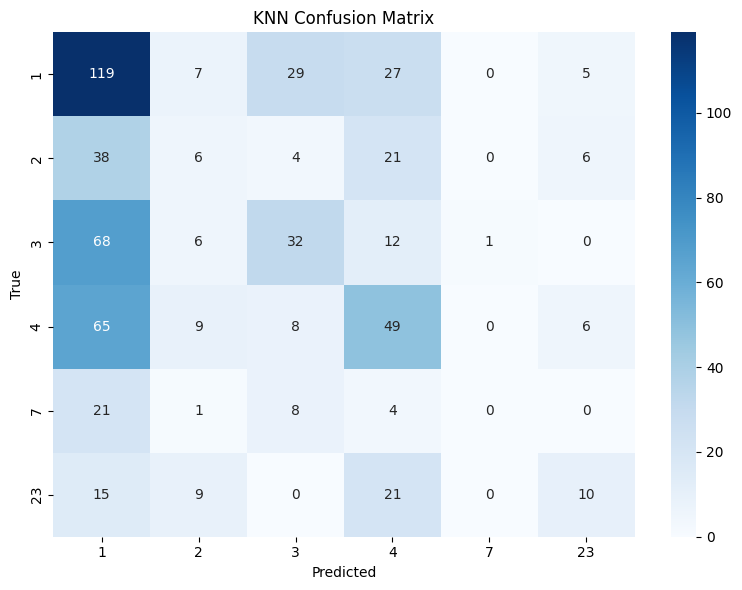

In [17]:
# ====== 1. Import required libraries ======
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ====== 2. Define features and target variable ======
# Assume you already have a DataFrame named df containing the following variables
features = ['nativism', 'msexism', 'femdemonstrate', 'female', 'dhincome_all']
target = 'voteintentionspain'

# ====== 3. Standardize continuous features ======
df_scaled = df.copy()

scaler = StandardScaler()
df_scaled[['nativism', 'msexism', 'dhincome_all']] = scaler.fit_transform(
    df_scaled[['nativism', 'msexism', 'dhincome_all']]
)

df_scaled['female'] = df_scaled['female'].astype(int)
df_scaled['femdemonstrate'] = df_scaled['femdemonstrate'].astype(int)

# ====== 4. Split into training and testing sets ======
X = df_scaled[features]
y = df_scaled[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ====== 5. Find the optimal number of neighbors (K) ======
k_values = range(1, 101)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]
print(f"✅ Best K = {best_k}, CV Accuracy = {max(cv_scores):.3f}")

# ====== 6. Visualize K vs Accuracy ======
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Hyperparameter Tuning')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best K = {best_k}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ====== 7. Train model with best K and predict ======
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

# ====== 8. Output classification report ======
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# ====== 9. Visualize confusion matrix ======
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


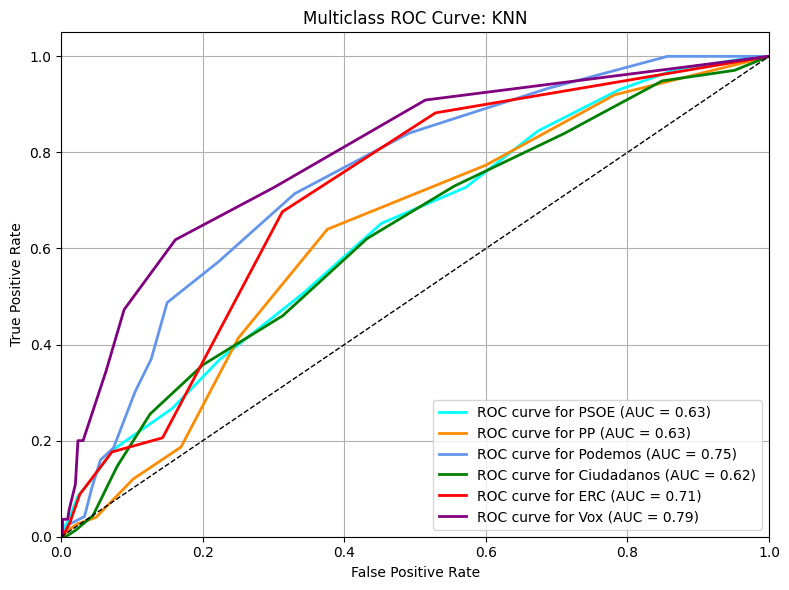


Macro Average AUC: 0.688


In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Mapping of voteintentionspain values to party names
party_map = {
    1: 'PSOE',
    2: 'PP',
    3: 'Podemos',
    4: 'Ciudadanos',
    7: 'ERC',
    23: 'Vox'
}

# Ensure party labels are in the same order as knn_best.classes_
party_labels = [party_map[i] for i in knn_best.classes_]

# Make sure the model outputs predicted probabilities
y_score = knn_best.predict_proba(X_test)
classes = knn_best.classes_

# Binarize true labels for ROC computation (One-vs-Rest format)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Compute False Positive Rate, True Positive Rate, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the multiclass ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {party_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve: KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print macro-average AUC
mean_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro Average AUC: {mean_auc:.3f}")


3.4 XGBoost Classifier

📋 Classification Report:
              precision    recall  f1-score   support

           1       0.38      0.51      0.44       187
           2       0.22      0.13      0.17        75
           3       0.44      0.35      0.39       119
           4       0.31      0.32      0.31       137
           7       0.10      0.06      0.07        34
          23       0.28      0.25      0.27        55

    accuracy                           0.34       607
   macro avg       0.29      0.27      0.27       607
weighted avg       0.33      0.34      0.33       607



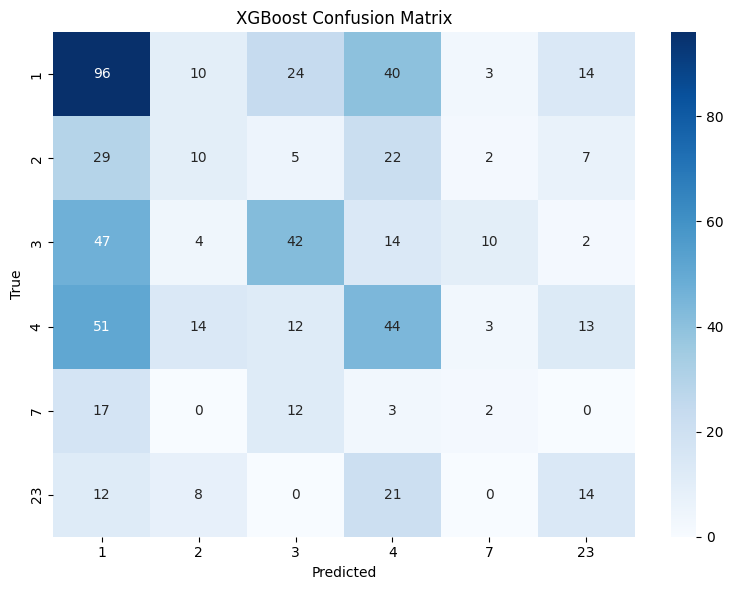

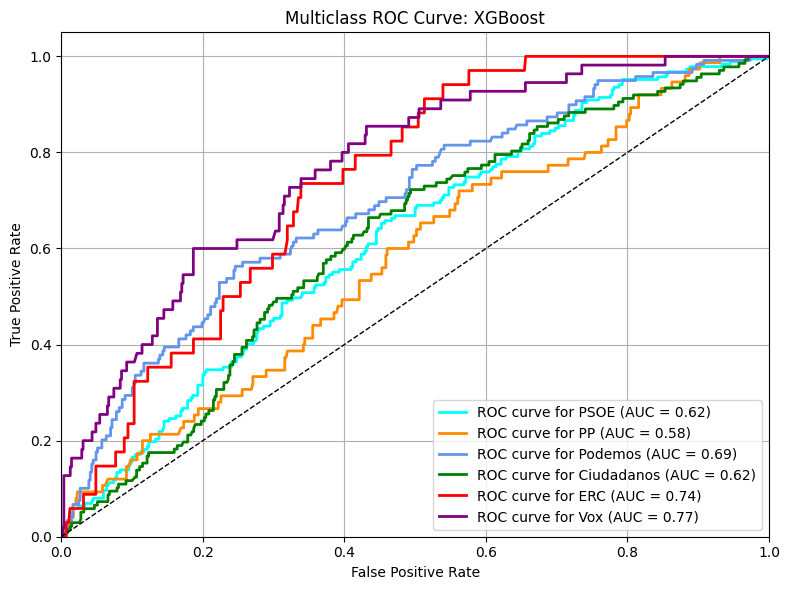


Macro Average AUC: 0.670


In [19]:
# ====== 1. Import Libraries ======
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from itertools import cycle

# ====== 2. Define features and target ======
features = ['nativism', 'msexism', 'femdemonstrate', 'female', 'dhincome_all']
target = 'voteintentionspain'

# ====== 3. Standardize continuous variables ======
df_scaled = df.copy()
scaler = StandardScaler()
df_scaled[['nativism', 'msexism', 'dhincome_all']] = scaler.fit_transform(
    df_scaled[['nativism', 'msexism', 'dhincome_all']]
)
df_scaled['female'] = df_scaled['female'].astype(int)
df_scaled['femdemonstrate'] = df_scaled['femdemonstrate'].astype(int)

# ====== 4. Encode target labels ======
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_scaled[target])
class_names = label_encoder.classes_  # [1, 2, 3, 4, 7, 23]

X = df_scaled[features]
y = y_encoded

# ====== 5. Split dataset ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ====== 6. Fit XGBoost Classifier ======
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train)

# ====== 7. Predict ======
y_pred_encoded = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test)

# ====== 8. Classification Report ======
print("📋 Classification Report:")
print(classification_report(y_test_original, y_pred))

# ====== 9. Confusion Matrix ======
cm = confusion_matrix(y_test_original, y_pred, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ====== 10. ROC Curve ======
# Map party values to labels
party_map = {
    1: 'PSOE', 2: 'PP', 3: 'Podemos', 4: 'Ciudadanos', 7: 'ERC', 23: 'Vox'
}
party_labels = [party_map[c] for c in class_names]

# Binarize true labels for ROC curve
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {party_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve: XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ====== 11. Print Macro AUC ======
mean_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro Average AUC: {mean_auc:.3f}")